## Load required libraries and assigning path to existing data

In [1]:
from __future__ import annotations
import numpy as np
import json
import time
from maml.apps.pes import EnergyForceStress
from auxiliary_functions import (
    get_data, 
    calculate_formation_energy, 
    plot_correlations,
    get_other_energies,
    )

filepath_daics_sio = "./data/daics/daics_Si-O.json"
# filepath_daics_sic = "./data/daics/daics_Si-C.json"
# filepath_mp = "./data/matbench/mp_e_form.json"
filepath_calcs_sio = "./data/calcs/Si-O_vasprunxml.json"

/home/zahed/Documents/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading data for training the model
### 400 Si-O structures generated randomly by USPEX, and optimized by VASP

In [2]:
data = get_data(filepath_calcs_sio, type="calcs")
train_structures = [d["structure"] for d in data]
train_energies = [d["energy"] for d in data]
train_forces = [d["forces"] for d in data]
train_stresses = [d["stress"] for d in data]

/home/zahed/Documents/env/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1186: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))


## Reading data for testing the model - data source: https://daics.net

In [3]:
# Lowest energy per atom for each element (eV/atom) | source: https://daics.net
element_energies = {"Si": -5.42242325, "O": -4.96043175}

# New data
newdata = get_data(filepath_daics_sio, type="daics")
test_structures = [d["structure"] for d in newdata]
test_energies = [d["energy"] for d in newdata]

# 1 - Gaussian Approximation Potential (GAP)
### Requirements: quippy, lammps, gap

## Set up and train GAP

In [4]:
from maml.apps.pes import GAPotential
gap = GAPotential()

start_time = time.time()
# Train the potential
gap.train(
    train_structures=train_structures,
    train_energies=train_energies,
    train_forces=train_forces,
    sparse_method="cur_points",    # Dynamically select sparse points
    l_max=8,                       # Angular resolution
    n_max=8,                       # Radial resolution
    e0=-0.97,                      # Reference cohesive energy per atom
    n_sparse=200,                  # Increase sparse points for better representation
    cutoff=5.0,                    # Cutoff radius (angstrom) for capturing interactions
)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

# Write the parameters to a file
gap.write_param("gap_SiO.xml")

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

Training completed in 3.17 minutes.


['pair_style        quip',
 'pair_coeff        * * gap_SiO.xml "Potential xml_label=GAP_2024_12_2_60_18_50_4_8" 14 8']

## Predict the energies, forces of training data for evaluation

In [5]:
df_orig, df_predict = gap.evaluate(
    test_structures=train_structures, test_energies=train_energies, test_forces=train_forces, test_stresses=None
)

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

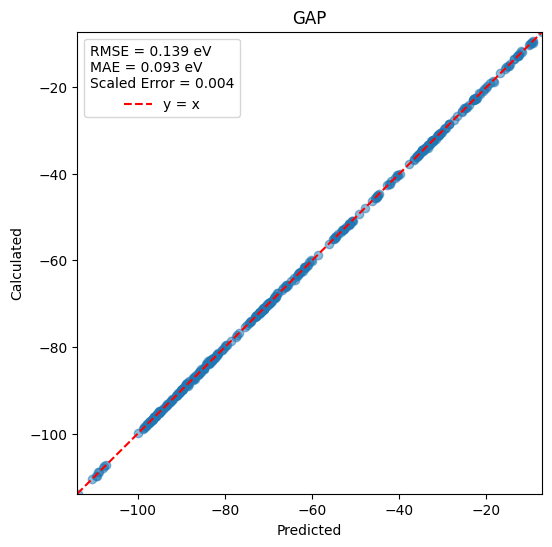

In [6]:
pred = df_predict[df_predict["dtype"] == "energy"]["y_orig"]
calc = df_orig[df_orig["dtype"] == "energy"]["y_orig"]
merged_array = np.column_stack((pred, calc))
plot_correlations(merged_array, "Predicted", "Calculated", "GAP")

## Prediction of Energies, Forces, and Stresses using the pre-trained model

### Load from parameters files

In [30]:
# from maml.apps.pes import GAPotential
gap_loaded = GAPotential.from_config(filename="gap_SiO.xml")

In [36]:
# Use EnergyForceStress for the LAMMPS-based GAPotential
efs_calculator = EnergyForceStress(ff_settings=gap, lmp_exe="lmp")

start_time = time.time()
energies = {}
for i in range(len(test_structures)): # 382 structures
# for i in range(20):
    struct = test_structures[i]
    energy = test_energies[i]
    composition = struct.composition.get_el_amt_dict()
    
    # Calculate formation energy
    formation_energy = calculate_formation_energy(energy, composition, element_energies)

    # Calculate only the energy (forces and stresses ignored)
    predicted_energy, predicted_forces, predicted_stresses = efs_calculator.calculate([struct])[0]
    formation_energy_predicted = calculate_formation_energy(predicted_energy, composition, element_energies)

    energies[i] = {
        "num_sites": struct.num_sites,
        "energy": energy, 
        "predicted_energy": predicted_energy, 
        "formation_energy": formation_energy, 
        "formation_energy_predicted": formation_energy_predicted
        }
    print(f"Actual energy: {energy}, Predicted energy: {predicted_energy}")
    
with open("SiO_energies_gap.json", "w") as f:
    json.dump(energies, f)
    
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

Actual energy: -789.56319, Predicted energy: -744.526518479399
Actual energy: -43.647755, Predicted energy: -44.1450189957226
Actual energy: -59.223394, Predicted energy: -59.2893972416092
Actual energy: -46.627771, Predicted energy: -41.2857088370942
Actual energy: -133.08178, Predicted energy: -143.458895256259
Actual energy: -64.031602, Predicted energy: -64.8330320466724
Actual energy: -59.502443, Predicted energy: -58.8774687663073
Actual energy: -42.152488, Predicted energy: -41.7416949409802
Actual energy: -56.546298, Predicted energy: -60.503320149384
Actual energy: -43.556984, Predicted energy: -42.151915738361
Actual energy: -52.505696, Predicted energy: -51.1756672646511
Actual energy: -71.490354, Predicted energy: -73.7384473362338
Actual energy: -56.831949, Predicted energy: -59.6139236794254
Actual energy: -92.870601, Predicted energy: -92.5216666112961
Actual energy: -62.712248, Predicted energy: -65.6294110447257
Actual energy: -379.22687, Predicted energy: -358.3790409

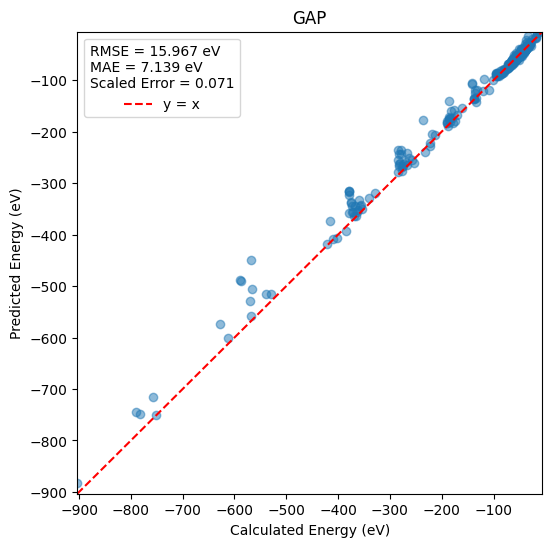

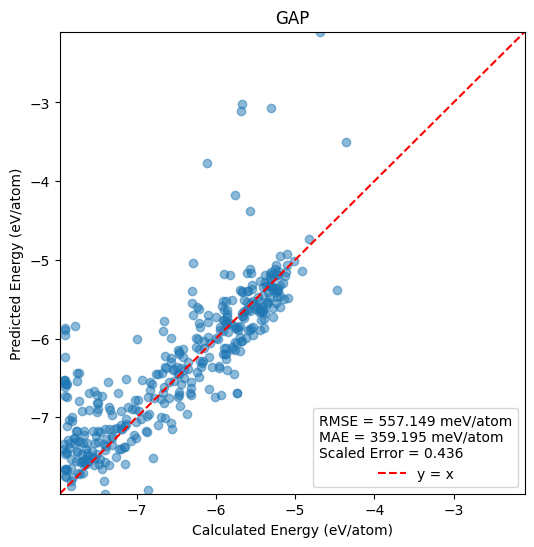

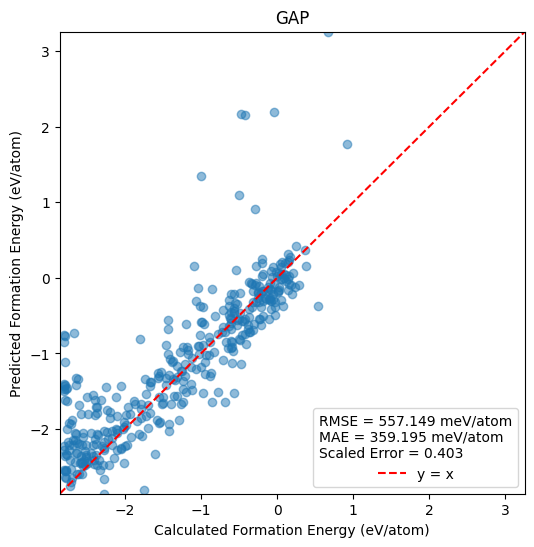

In [37]:
data_en, data_en_p_a, data_form_en = get_other_energies(energies)
    
plot_correlations(data_en, "Calculated Energy (eV)", "Predicted Energy (eV)", model="GAP")
plot_correlations(data_en_p_a, "Calculated Energy (eV/atom)", "Predicted Energy (eV/atom)", model="GAP", per_atom=True)
plot_correlations(data_form_en, "Calculated Formation Energy (eV/atom)", "Predicted Formation Energy (eV/atom)", model="GAP", per_atom=True)

# 2 - Spectral Neighbor Analysis Potential (SNAP)
### Requirements: lammps

### Setup the initial weights for training (If not, the weights for energy and force will be both equal to 1)

In [9]:
from maml.utils import convert_docs, pool_from

train_pool = pool_from(train_structures, train_energies, train_forces)
_, df = convert_docs(train_pool)

weights = np.ones(
    len(df["dtype"]),
)

# set the weights for energy equal to 100
weights[df["dtype"] == "energy"] = 100

## Set up the SNAP and train

In [10]:
from sklearn.linear_model import LinearRegression

from maml.apps.pes import SNAPotential
from maml.base import SKLModel
from maml.describers import BispectrumCoefficients

# r: cutoff radius, w: weight
element_profile = {
    "Si": {"r": 5.0, "w": 1},
    "O": {"r": 5.0, "w": 1}
}
start_time = time.time()
describer = BispectrumCoefficients(
    rcutfac=0.5, twojmax=6, element_profile=element_profile, quadratic=False, pot_fit=True
)
model = SKLModel(describer=describer, model=LinearRegression())
snap = SNAPotential(model=model)
snap.train(train_structures, train_energies, train_forces, sample_weight=weights)
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.apps.pes._lammps:Setting Lammps executable to /home/zahed/softs/lammps/build/lmp
INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index

Training completed in 4.63 minutes.


In [11]:
# SNAPotential.snapcoeff, SNAPotential.snapparam
snap.write_param()

['pair_style        snap',
 'pair_coeff        * * SNAPotential.snapcoeff SNAPotential.snapparam Si O']

## Predict the energies, forces of training data for evaluation

In [ ]:
df_orig, df_predict = snap.evaluate(
    test_structures=train_structures, test_energies=train_energies, test_forces=train_forces, test_stresses=None
)

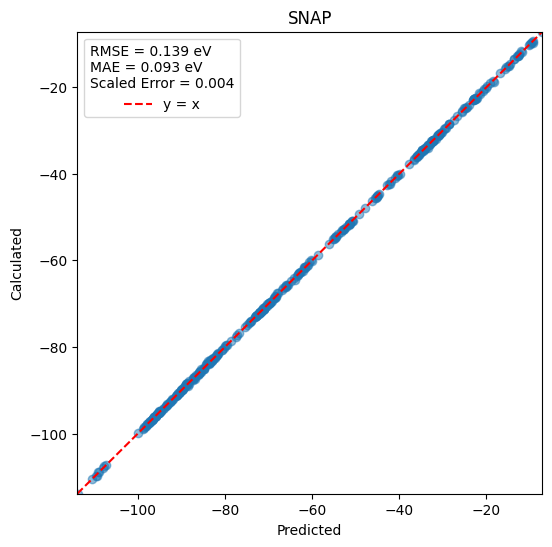

In [12]:
pred = df_predict[df_predict["dtype"] == "energy"]["y_orig"]
calc = df_orig[df_orig["dtype"] == "energy"]["y_orig"]
merged_array = np.column_stack((pred, calc))
plot_correlations(merged_array, "Predicted", "Calculated", "SNAP")

## Prediction of Energies, Forces, and Stresses using the pre-trained model

### Load from parameters files

In [ ]:
# from maml.apps.pes import SNAPotential
# snap_loaded = SNAPotential.from_config(param_file="SNAPotential.snapparam", coeff_file="SNAPotential.snapcoeff")

In [38]:
from maml.apps.pes import EnergyForceStress

start_time = time.time()
efs_calculator = EnergyForceStress(ff_settings=snap)
# efs_calculator = EnergyForceStress(ff_settings=snap_loaded, lmp_exe="/home/zahed/softs/lammps/build/lmp")
energies = {}
for i in range(len(test_structures)): # 382 structures
# for i in range(10):
    struct = test_structures[i]
    energy = test_energies[i]
    composition = struct.composition.get_el_amt_dict()
    
    # Calculate formation energy
    formation_energy = calculate_formation_energy(energy, composition, element_energies)

    # Calculate only the energy (forces and stresses ignored)
    predicted_energy, predicted_forces, predicted_stresses = efs_calculator.calculate([struct])[0]
    formation_energy_predicted = calculate_formation_energy(predicted_energy, composition, element_energies)

    energies[i] = {
        "num_sites": struct.num_sites,
        "energy": energy, 
        "predicted_energy": predicted_energy, 
        "formation_energy": formation_energy, 
        "formation_energy_predicted": formation_energy_predicted
        }
    print(f"Actual energy: {energy}, Predicted energy: {predicted_energy}")
    
with open("SiO_energies_snap.json", "w") as f:
    json.dump(energies, f)
    
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.apps.pes._lammps:Setting Lammps executable to /home/zahed/softs/lammps/build/lmp


Actual energy: -789.56319, Predicted energy: -680.107006530242
Actual energy: -43.647755, Predicted energy: -45.4325913018691
Actual energy: -59.223394, Predicted energy: -53.7903693021087
Actual energy: -46.627771, Predicted energy: -41.6932437019687
Actual energy: -133.08178, Predicted energy: -118.565377013616
Actual energy: -64.031602, Predicted energy: -67.7766853842454
Actual energy: -59.502443, Predicted energy: -61.1237722796206
Actual energy: -42.152488, Predicted energy: -44.7034102721243
Actual energy: -56.546298, Predicted energy: -60.3618827971967
Actual energy: -43.556984, Predicted energy: -45.0509960118087
Actual energy: -52.505696, Predicted energy: -56.941835266045
Actual energy: -71.490354, Predicted energy: -64.7555803745043
Actual energy: -56.831949, Predicted energy: -54.887368499296
Actual energy: -92.870601, Predicted energy: -83.2389394035524
Actual energy: -62.712248, Predicted energy: -67.9912604003677
Actual energy: -379.22687, Predicted energy: -321.4880627

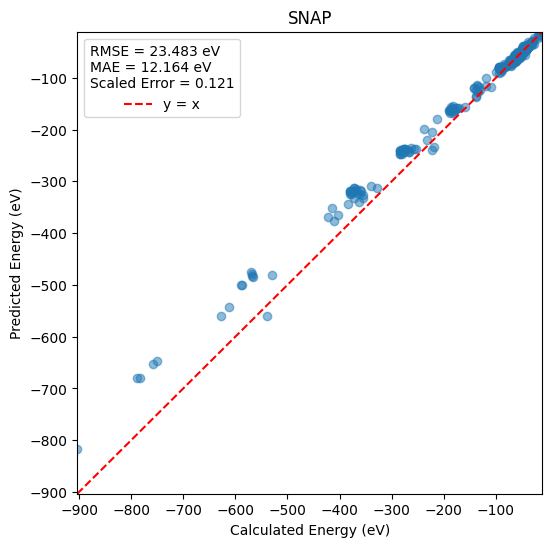

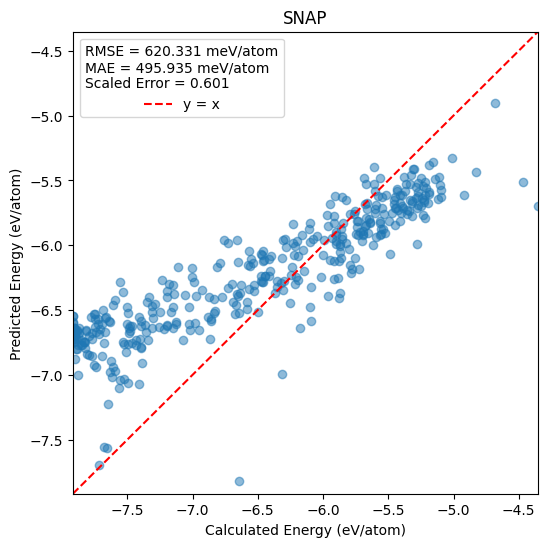

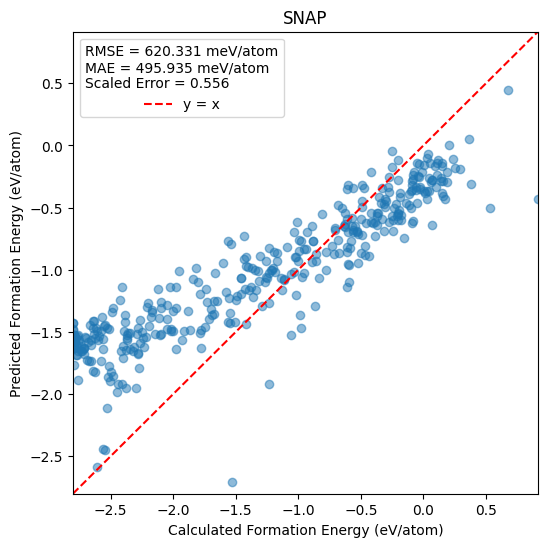

In [39]:
data_en, data_en_p_a, data_form_en = get_other_energies(energies)
    
plot_correlations(data_en, "Calculated Energy (eV)", "Predicted Energy (eV)", model="SNAP")
plot_correlations(data_en_p_a, "Calculated Energy (eV/atom)", "Predicted Energy (eV/atom)", model="SNAP", per_atom=True)
plot_correlations(data_form_en, "Calculated Formation Energy (eV/atom)", "Predicted Formation Energy (eV/atom)", model="SNAP", per_atom=True)

## 3 - quadratic Spectral Neighbor Analysis Potential (qSNAP)
### Requirements: lammps

### Setup the initial weights for training (If not, the weights for energy and force will be both equal to 1)

In [16]:
from maml.utils import convert_docs, pool_from

train_pool = pool_from(train_structures, train_energies, train_forces)
_, df = convert_docs(train_pool)

weights = np.ones(
    len(df["dtype"]),
)

# set the weights for energy equal to 100
weights[df["dtype"] == "energy"] = 100

## Set up the qSNAP and train

In [17]:
from sklearn.linear_model import LinearRegression
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from maml.describers import BispectrumCoefficients

# r: cutoff radius, w: weight
element_profile = {
    "Si": {"r": 5.0, "w": 1},
    "O": {"r": 5.0, "w": 1}
}

start_time = time.time()
describer = BispectrumCoefficients(
    rcutfac=0.5, twojmax=6, element_profile=element_profile, quadratic=True, pot_fit=True
)
model = SKLModel(describer=describer, model=LinearRegression())
qsnap = SNAPotential(model=model)
qsnap.train(train_structures, train_energies, train_forces, sample_weight=weights)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.apps.pes._lammps:Setting Lammps executable to /home/zahed/softs/lammps/build/lmp
INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index

Training completed in 5.89 minutes.


In [18]:
# SNAPotential.snapcoeff, SNAPotential.snapparam
qsnap.write_param()

['pair_style        snap',
 'pair_coeff        * * SNAPotential.snapcoeff SNAPotential.snapparam Si O']

## Predict the energies, forces of training data for evaluation

In [19]:
df_orig, df_predict = qsnap.evaluate(
    test_structures=train_structures, test_energies=train_energies, test_forces=train_forces, test_stresses=None
)

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

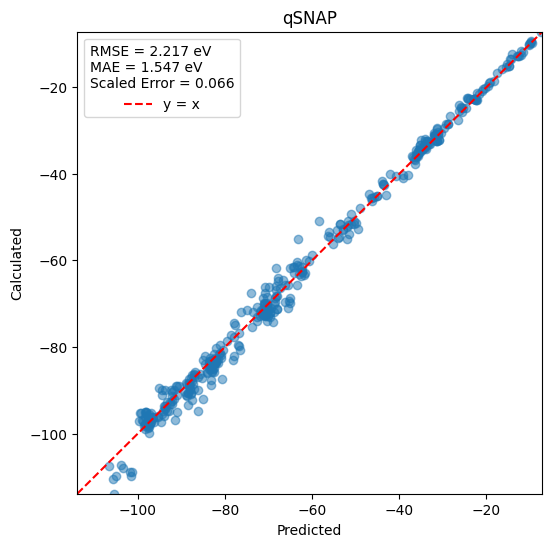

In [20]:
pred = df_predict[df_predict["dtype"] == "energy"]["y_orig"]
calc = df_orig[df_orig["dtype"] == "energy"]["y_orig"]
merged_array = np.column_stack((pred, calc))
plot_correlations(merged_array, "Predicted", "Calculated", "qSNAP")

## Prediction of Energies, Forces, and Stresses using the pre-trained model

In [ ]:
# from maml.apps.pes import SNAPotential
# qsnap_loaded = SNAPotential.from_config(param_file="SNAPotential.snapparam", coeff_file="SNAPotential.snapcoeff")

In [41]:
from maml.apps.pes import EnergyForceStress

# efs_calculator = EnergyForceStress(ff_settings=qsnap_loaded)
efs_calculator = EnergyForceStress(ff_settings=qsnap)

start_time = time.time()
energies = {}

for i in range(len(test_structures)): # 382 structures
# for i in range(10):
    struct = test_structures[i]
    energy = test_energies[i]
    composition = struct.composition.get_el_amt_dict()
    
    # Calculate formation energy
    formation_energy = calculate_formation_energy(energy, composition, element_energies)

    # Calculate only the energy (forces and stresses ignored)
    predicted_energy, predicted_forces, predicted_stresses = efs_calculator.calculate([struct])[0]
    formation_energy_predicted = calculate_formation_energy(predicted_energy, composition, element_energies)

    energies[i] = {
        "num_sites": struct.num_sites,
        "energy": energy, 
        "predicted_energy": predicted_energy, 
        "formation_energy": formation_energy, 
        "formation_energy_predicted": formation_energy_predicted
        }
    print(f"Actual energy: {energy}, Predicted energy: {predicted_energy}")
    
with open("SiO_energies_qsnap.json", "w") as f:
    json.dump(energies, f)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.apps.pes._lammps:Setting Lammps executable to /home/zahed/softs/lammps/build/lmp


Actual energy: -789.56319, Predicted energy: -712.406524046748
Actual energy: -43.647755, Predicted energy: -45.7491416666326
Actual energy: -59.223394, Predicted energy: -54.3455881888738
Actual energy: -46.627771, Predicted energy: -43.2761402533293
Actual energy: -133.08178, Predicted energy: -118.408308016201
Actual energy: -64.031602, Predicted energy: -66.7909963553697
Actual energy: -59.502443, Predicted energy: -61.4908125465791
Actual energy: -42.152488, Predicted energy: -44.7998949656819
Actual energy: -56.546298, Predicted energy: -60.1666024075433
Actual energy: -43.556984, Predicted energy: -46.1831633035335
Actual energy: -52.505696, Predicted energy: -56.2012315952843
Actual energy: -71.490354, Predicted energy: -66.2337681529056
Actual energy: -56.831949, Predicted energy: -55.9562874838848
Actual energy: -92.870601, Predicted energy: -85.9293915629481
Actual energy: -62.712248, Predicted energy: -67.2550682900464
Actual energy: -379.22687, Predicted energy: -345.48038

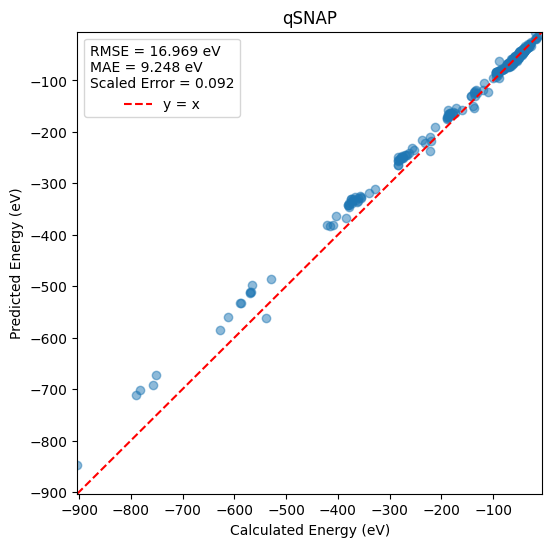

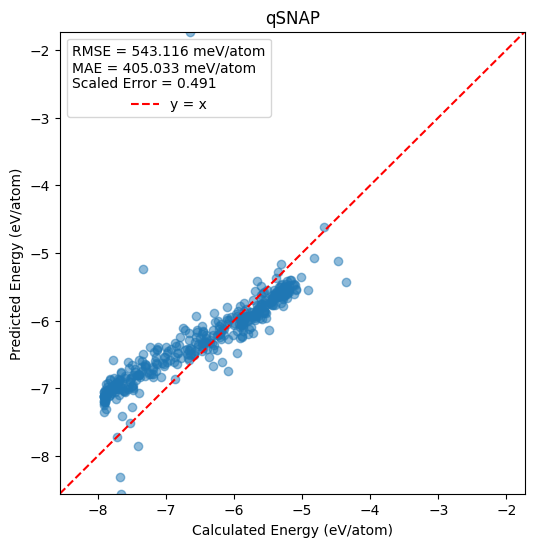

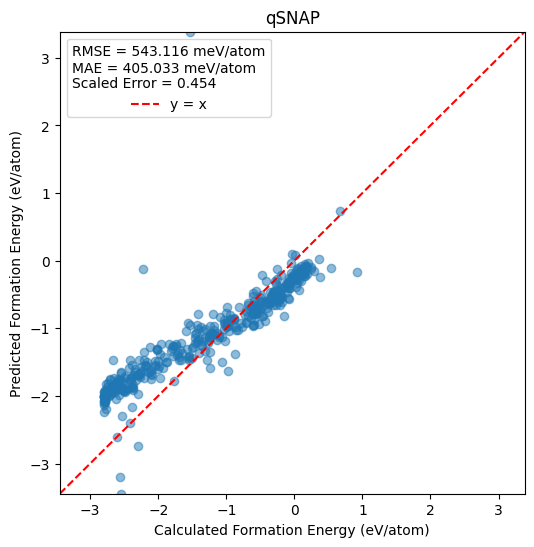

In [42]:
data_en, data_en_p_a, data_form_en = get_other_energies(energies)
    
plot_correlations(data_en, "Calculated Energy (eV)", "Predicted Energy (eV)", model="qSNAP")
plot_correlations(data_en_p_a, "Calculated Energy (eV/atom)", "Predicted Energy (eV/atom)", model="qSNAP", per_atom=True)
plot_correlations(data_form_en, "Calculated Formation Energy (eV/atom)", "Predicted Formation Energy (eV/atom)", model="qSNAP", per_atom=True)

## 4 - Behler-Parrinello Neural Network Potentials (NNPs)
### Requirements: n2p2 (Neural Network Potential Package), lammps

### **NOTE** the maml package is not updated regarding the recent modifications of lammps inputs for NNP
### Please consult the documentaion below:
#### https://compphysvienna.github.io/n2p2/interfaces/if_lammps.html

## Set up the NNP and train

In [23]:
from maml.apps.pes import NNPotential

start_time = time.time()
nnp = NNPotential()
nnp.train(
    train_structures=train_structures,
    train_energies=train_energies,
    train_forces=train_forces,
    cutoff_type=1,                          # Cosine cutoff
    atom_energy={"Si": -5.43, "O": -4.96},  # Atomic reference energies (adjust as needed)
    r_etas=[0.2, 1.0, 4.0],                 # Radial symmetry function widths
    a_etas=[0.1, 0.5, 2.0],                 # Angular symmetry function widths
    r_shift=[0.0, 0.5],                     # Radial function offsets
    zetas=[1.0, 4.0],                       # Angular terms
    r_cut=5.5,                              # Cutoff radius
    hidden_layers=[16, 16],                 # Neural network architecture
    epochs=300,                             # Training iterations
)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

Training completed in 48.05 minutes.


In [24]:
nnp.write_param() # input.nn, scaling.data, weights.008.data, weights.014.data

['pair_style        nnp dir "./" showew no showewsum 0 maxew 10000000 resetew yes cflength 1.8897261328 cfenergy 0.0367493254',
 'pair_coeff        * * 5.51']

## Predict the energies, forces of training data for evaluation

In [25]:
df_orig, df_predict = nnp.evaluate(
    test_structures=train_structures, test_energies=train_energies, test_forces=train_forces, test_stresses=None
)

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

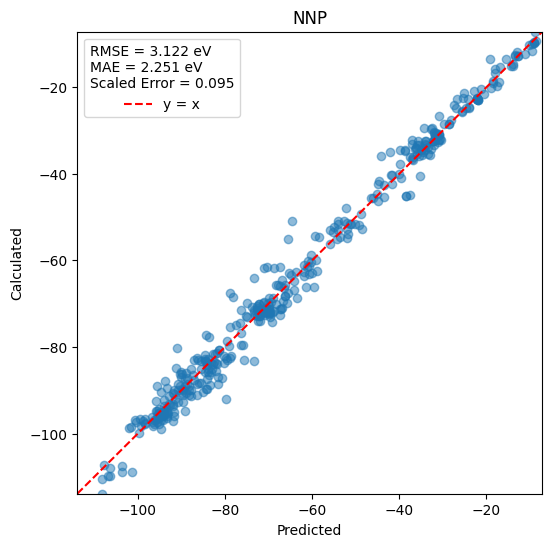

In [26]:
pred = df_predict[df_predict["dtype"] == "energy"]["y_orig"]
calc = df_orig[df_orig["dtype"] == "energy"]["y_orig"]
merged_array = np.column_stack((pred, calc))
plot_correlations(merged_array, "Predicted", "Calculated", "NNP")

## Prediction of Energies, Forces, and Stresses using the pre-trained model

### Load from parameters files

In [4]:
# from maml.apps.pes import NNPotential
nnp_loaded = NNPotential.from_config(
    input_filename="input.nn",
    scaling_filename="scaling.data",
    weights_filenames=["weights.008.data", "weights.014.data"],
)

In [9]:
from maml.apps.pes import EnergyForceStress

efs_calculator = EnergyForceStress(ff_settings=nnp_loaded)

start_time = time.time()
energies = {}
for i in range(len(test_structures)): # 382 structures
# for i in range(10):
    struct = test_structures[i]
    energy = test_energies[i]
    composition = struct.composition.get_el_amt_dict()
    
    # Calculate formation energy
    formation_energy = calculate_formation_energy(energy, composition, element_energies)

    # Calculate only the energy (forces and stresses ignored)
    predicted_energy, predicted_forces, predicted_stresses = efs_calculator.calculate([struct])[0]
    formation_energy_predicted = calculate_formation_energy(predicted_energy, composition, element_energies)

    energies[i] = {
        "num_sites": struct.num_sites,
        "energy": energy, 
        "predicted_energy": predicted_energy, 
        "formation_energy": formation_energy, 
        "formation_energy_predicted": formation_energy_predicted
        }
    print(f"Actual energy: {energy}, Predicted energy: {predicted_energy}")
    
with open("SiO_energies_nnp.json", "w") as f:
    json.dump(energies, f)
    
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.apps.pes._lammps:Setting Lammps executable to /home/zahed/softs/lammps/build/lmp


in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -789.56319, Predicted energy: -159.649359753613
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -43.647755, Predicted energy: -122.94551729308
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -59.223394, Predicted energy: -22.1347181005816
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -46.627771, Predicted energy: -58.9395440774198
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -133.08178, Predicted energy: -29.2327919657427
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -64.031602, Predicted energy: -195.337758631808
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -59.502443, Predicted energy: -87.003284979735
in.efs
['/home/zahed/softs/lammps/build/lmp', '-in', 'in.efs']
Actual energy: -42.152488, Predicted energy: 25.421028901

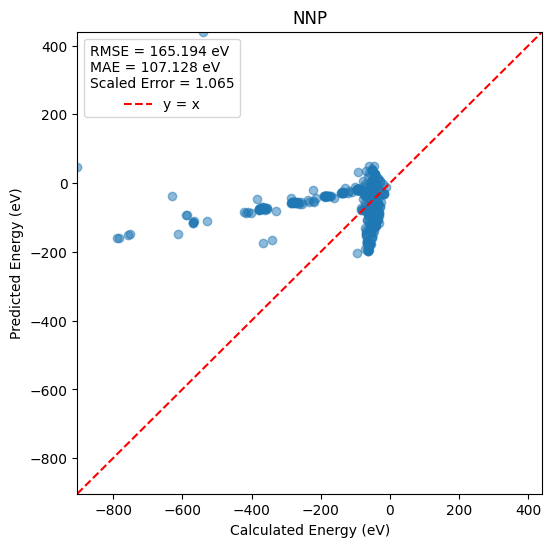

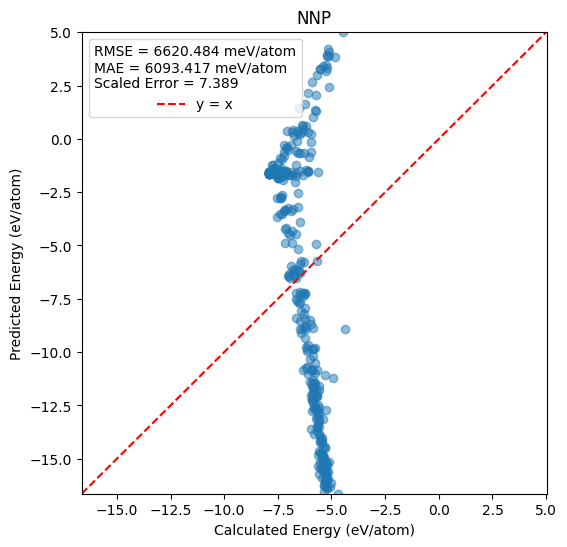

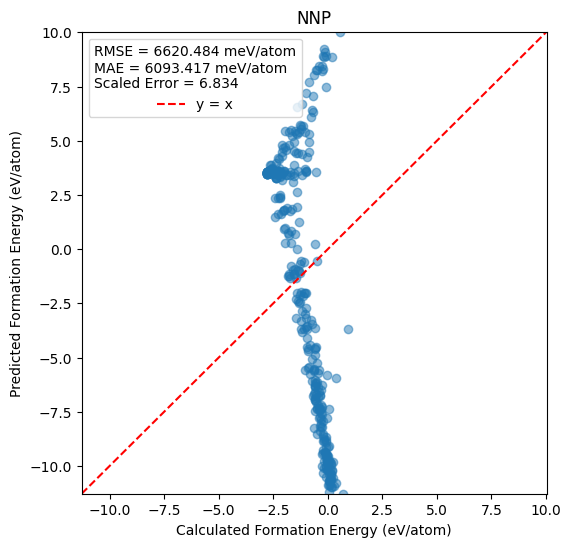

In [10]:
data_en, data_en_p_a, data_form_en = get_other_energies(energies)
    
plot_correlations(data_en, "Calculated Energy (eV)", "Predicted Energy (eV)", model="NNP")
plot_correlations(data_en_p_a, "Calculated Energy (eV/atom)", "Predicted Energy (eV/atom)", model="NNP", per_atom=True)
plot_correlations(data_form_en, "Calculated Formation Energy (eV/atom)", "Predicted Formation Energy (eV/atom)", model="NNP", per_atom=True)

## 5 - Moment Tensor Potentials (MTP)
### Requirements: MLIP, lammps

# Set up the MTP and train

In [43]:
from maml.apps.pes import MTPotential

start_time = time.time()
mtp = MTPotential()

mtp.train(
    train_structures=train_structures,
    train_energies=train_energies,
    train_forces=train_forces,
    train_stresses=None,
    max_dist=5,
    stress_weight=0,
)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.


INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lammps:Structure index 18 is rotated.
INFO:maml.utils._lammps:Structure index 19 is rotated.
INFO:maml.utils._lammps:Structure index 20 is rotated.
INFO:maml.utils._lammps:Structure index 21 is rotated.
INFO:maml.utils.

Training completed in 12.31 minutes.


In [44]:
mtp.write_param(fitted_mtp="fitted.mtp")

['pair_style        mlip mlip.ini', 'pair_coeff        * *']

## Predict the energies, forces of training data for evaluation

In [45]:
df_orig, df_predict = mtp.evaluate(
    test_structures=train_structures, test_energies=train_energies, test_forces=train_forces, test_stresses=None
)

INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:maml.utils._lammps:Structure index 17 is rotated.
INFO:maml.utils._lam

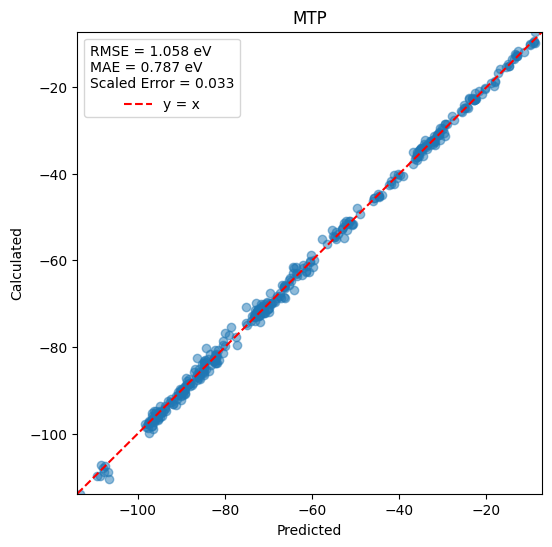

In [46]:
pred = df_predict[df_predict["dtype"] == "energy"]["y_orig"]
calc = df_orig[df_orig["dtype"] == "energy"]["y_orig"]
merged_array = np.column_stack((pred, calc))
plot_correlations(merged_array, "Predicted", "Calculated", "MTP")

## Prediction of Energies, Forces, and Stresses using the pre-trained model

### Load from parameters files

In [5]:
# from maml.apps.pes import MTPotential
mtp_loaded = MTPotential.from_config(filename="fitted.mtp", elements=["Si", "O"])

In [6]:
from maml.apps.pes import EnergyForceStress

efs_calculator = EnergyForceStress(ff_settings=mtp_loaded, lmp_exe="/home/zahed/softs/lammps/build/lmp")

start_time = time.time()
energies = {}
for i in range(len(test_structures)):
    struct = test_structures[i]
    energy = test_energies[i]
    composition = struct.composition.get_el_amt_dict()
    
    # Calculate formation energy
    formation_energy = calculate_formation_energy(energy, composition, element_energies)

    # Calculate only the energy (forces and stresses ignored)
    predicted_energy, predicted_forces, predicted_stresses = efs_calculator.calculate([struct])[0]
    formation_energy_predicted = calculate_formation_energy(predicted_energy, composition, element_energies)

    energies[i] = {
        "num_sites": struct.num_sites,
        "energy": energy, 
        "predicted_energy": predicted_energy, 
        "formation_energy": formation_energy, 
        "formation_energy_predicted": formation_energy_predicted
        }
    print(f"Actual energy: {energy}, Predicted energy: {predicted_energy}")
    
with open("SiO_energies_mtp.json", "w") as f:
    json.dump(energies, f)
    
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Training completed in {elapsed_minutes:.2f} minutes.")

RuntimeError: LAMMPS exited with return code 1ERROR: Unrecognized pair style 'mlip' (src/force.cpp:275), Last command: pair_style        mlip mlip.ini

In [ ]:
data_en, data_en_p_a, data_form_en = get_other_energies(energies)
    
plot_correlations(data_en, "Calculated Energy (eV)", "Predicted Energy (eV)", model="qSNAP")
plot_correlations(data_en_p_a, "Calculated Energy (eV/atom)", "Predicted Energy (eV/atom)", model="qSNAP", to_mev=False)
plot_correlations(data_form_en, "Calculated Formation Energy (eV/atom)", "Predicted Formation Energy (eV/atom)", model="qSNAP", to_mev=False)